In [5]:
import os
from collections import defaultdict

import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib import rcParams

In [6]:
get_data = lambda path:  pd.read_excel(path,engine="openpyxl", usecols="B:H")

In [7]:

logs_path = "../logs"

exp_data = defaultdict(dict)

for dataset in os.listdir(logs_path):
    
    model_results = defaultdict(dict)
    dataset_path = os.path.join(logs_path, dataset)
    
    for file in os.listdir(dataset_path):
        header = file.split("_")
        model = header[0]
        noise = header[1].split("-")[1]
        
        model_results[model][noise] = get_data(os.path.join(dataset_path, file))
        
    print(model_results.keys())
    exp_data[dataset] = dict(model_results)


dict_keys(['NeSymRes', 'gplearn', 'dsr', 'AIF'])
dict_keys(['dsr', 'AIF', 'gplearn', 'NeSymRes'])


In [8]:
dataset_df = {}

for dataset in os.listdir(logs_path):

    acc, tim = [], []

    df_dict = {
        "model":[],
        "accuracy":[],
        "noise":[],
        "duration":[]
    }    
    
    models = sorted(exp_data[dataset].keys())
    for model in models:
        
        noises = sorted(exp_data[dataset][model].keys(), key=lambda x: float(x))
        for noise in noises:
            
            df_col = exp_data[dataset][model][noise]
            
            acc = len(df_col[df_col["accuracy"]>=0.95])/len(df_col)        
            dur = exp_data[dataset][model][noise].describe()['time']['mean']

            df_dict["model"].append(model)
            df_dict["accuracy"].append(acc)
            df_dict["noise"].append(noise)
            df_dict["duration"].append(dur)            
            
    df = pd.DataFrame(data=df_dict)
    dataset_df[dataset] = df

In [9]:
# dataset_df.keys()
dataset_df["nguyen-12"]

,model,accuracy,noise,duration
0,AIF,0.916667,0.0,67.971069
1,AIF,0.750000,0.001,69.270454
2,AIF,0.416667,0.01,69.957258
3,AIF,0.000000,0.1,69.901183
4,NeSymRes,0.000000,0.0,18.905265
5,NeSymRes,0.083333,0.001,17.515344
6,NeSymRes,0.000000,0.01,17.693132
7,NeSymRes,0.000000,0.1,19.432809
8,dsr,0.916667,0.0,29.543257
9,dsr,0.833333,0.001,38.128427


AIF -1.0 -0.9166666666666666 0.0 0.9166666666666666
gplearn -1.0 -0.08333333333333333 0.0 0.08333333333333333
dsr -1.0 -0.9166666666666666 0.0 0.9166666666666666
NeSymRes 0 0.0 0.0 0.0


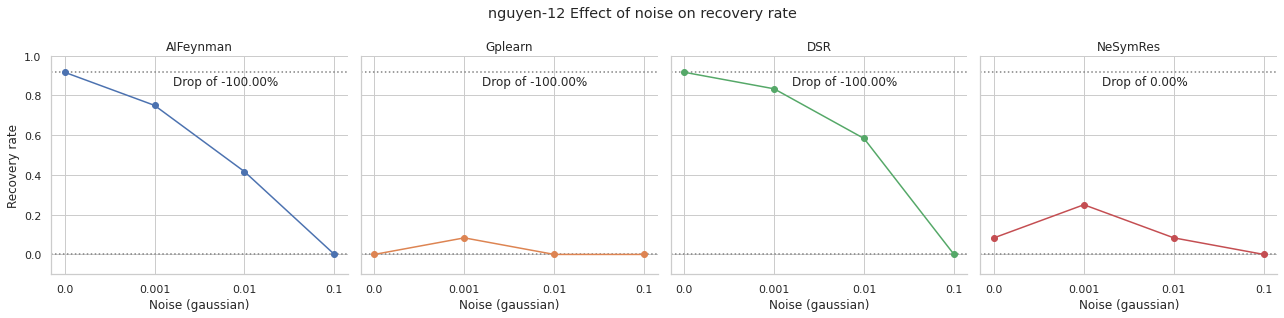

In [25]:
def show_recovery_vs_noise_plot(dataset: str="Feynman-03"):
    sns.set_theme(style="ticks")
    sns.set_style('whitegrid')
    
    grid = sns.FacetGrid(dataset_df[dataset], col="model", hue="model",
                         col_wrap=4, height=4.5)
    
    grid.fig.suptitle(dataset+" Effect of noise on recovery rate")

    grid.refline(y=dataset_df[dataset]['accuracy'].max(), linestyle=":")
    grid.refline(y=dataset_df[dataset]['accuracy'].min(), linestyle=":")

    grid.map(plt.plot, "noise", "accuracy", marker="o")

    grid.set_axis_labels("Noise (gaussian)", "Recovery rate")

    grid.set(ylim=(-0.1, 1.0))

    iterator = zip(
        grid.axes.flat, 
        ["AIF", "gplearn", "dsr", "NeSymRes"], 
        ["AIFeynman", "Gplearn", "DSR", "NeSymRes"]
    )

    for ax, model, title in iterator:
        ax.set_title(title)

        local_df = dataset_df[dataset][dataset_df[dataset]["model"]==model]

        no_noise_acc = float(local_df[local_df["noise"]=="0.0"]["accuracy"])
        most_noise_acc = float(local_df[local_df["noise"]=="0.1"]["accuracy"])
        
        change = most_noise_acc - no_noise_acc
        if change == 0:
            acc_change = 0
        else:
            acc_change = (change)/no_noise_acc
        
        if dataset=="nguyen-12":
            print(model, acc_change, change, most_noise_acc, no_noise_acc)
        
        ax.text(1.2, 0.85,f'Drop of {acc_change*100:.2f}%', fontsize=12)
        
def show_noise_vs_duration_plot(dataset: str="Feynman-03"):
    
    sns.set_theme(style="ticks")
    sns.set_style('whitegrid')
    
    grid = sns.FacetGrid(dataset_df[dataset], col="model", hue="model",
                         col_wrap=4, height=4.5)
    
    grid.fig.suptitle(dataset+" Effect of noise on recovery time")

    grid.refline(y=dataset_df[dataset]['duration'].max(), linestyle=":")
    grid.refline(y=dataset_df[dataset]['duration'].min(), linestyle=":")

    grid.map(plt.plot, "noise", "duration", marker="o")

    grid.set_axis_labels("Noise (gaussian)", "Avg recovery duration (sec)")


    iterator = zip(
        grid.axes.flat, 
        ["AIF", "gplearn", "dsr", "NeSymRes"], 
        ["AIFeynman", "Gplearn", "DSR", "NeSymRes"]
    )

    for ax, model, title in iterator:
        ax.set_title(title)

        local_df = dataset_df[dataset][dataset_df[dataset]["model"]==model]

        no_noise_dur = float(local_df[local_df["noise"]=="0.0"]["duration"])
        most_noise_dur = float(local_df[local_df["noise"]=="0.1"]["duration"])
        
        change = most_noise_dur - no_noise_dur
        if change == 0:
            dur_change = 0
        else:
            dur_change = (change)/no_noise_dur
        ax.text(0.15, 50,f'Drop of {dur_change*100:.2f}%', fontsize=12)

# show_recovery_vs_noise_plot()
# show_noise_vs_duration_plot()

show_recovery_vs_noise_plot("nguyen-12")
# show_noise_vs_duration_plot("nguyen-12")

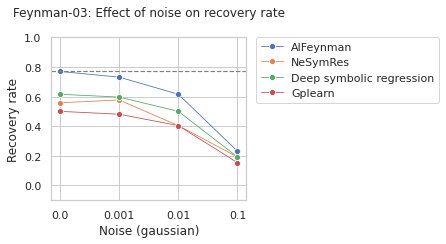

In [38]:
rcParams['figure.figsize'] = 3.5,3

def show_acc_plot(dataset:str="Feynman-03"):
    
    plt.xlabel('Noise (gaussian)')
    plt.ylabel('Recovery rate')
#     plt.tick_params(axis='both', which='major', labelsize=8)

    sns.set_theme(style="ticks")
    sns.set_style('whitegrid')

    fig = sns.lineplot(
        data=dataset_df[dataset],
        x="noise", y="accuracy", 
        hue="model", marker="o", 
        legend=False,
        linewidth = 0.8,
    )
    
    fig.set_title(f"{dataset}: Effect of noise on recovery rate\n")
    fig.axhline(dataset_df[dataset]["accuracy"].max(), linestyle="--", linewidth=1.2, color='gray')
    

    fig.set_ylim(-0.1, 1.0)
    plt.legend(["AIFeynman", "NeSymRes", "Deep symbolic regression", "Gplearn",], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
show_acc_plot("Feynman-03")

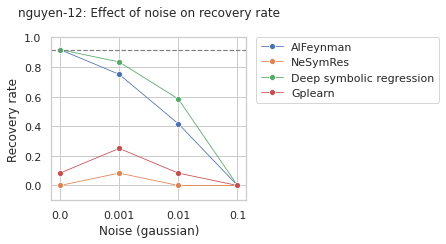

In [39]:
show_acc_plot("nguyen-12")